In [1]:
!pip install windrose

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
from windrose import WindroseAxes
import polars as pl
import os
import datetime

os.chdir(os.path.dirname(os.getcwd()))
import pytz

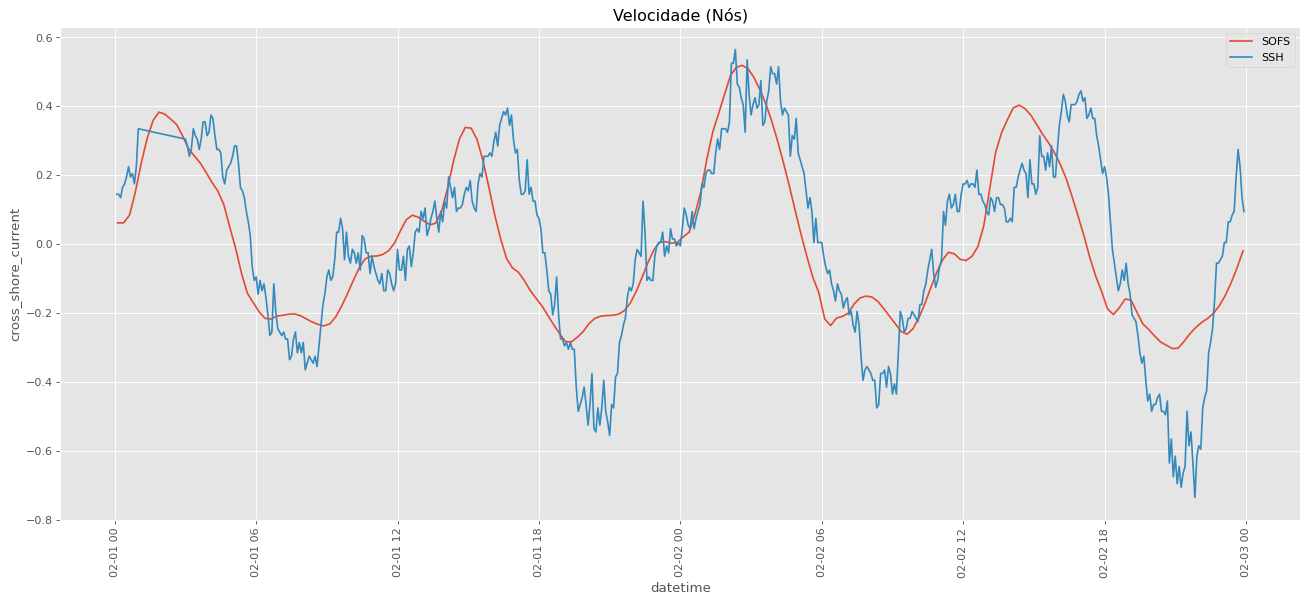

In [13]:
sofs = pl.read_parquet("data/02_processed/train/sofs_praticagem.parquet")
ssh = pl.read_parquet("data/02_processed/train/current_praticagem.parquet")
ssh = ssh.filter(
    [
        (
            (pl.col("datetime") > datetime.datetime(2019, 2, 1, tzinfo=pytz.UTC))
            & (pl.col("datetime") < datetime.datetime(2019, 2, 3, tzinfo=pytz.UTC))
        )
    ]
).with_columns([(pl.col("cross_shore_current") - pl.col("cross_shore_current").mean())])
sofs = sofs.filter(
    [
        (
            (pl.col("datetime") > datetime.datetime(2019, 2, 1, tzinfo=pytz.UTC))
            & (pl.col("datetime") < datetime.datetime(2019, 2, 3, tzinfo=pytz.UTC))
        )
    ]
).with_columns([(pl.col("cross_shore_current") - pl.col("cross_shore_current").mean())])

plt.style.use("ggplot")
plt.figure(figsize=(20, 8), dpi=80)
sns.lineplot(data=sofs.to_pandas(), x="datetime", y="cross_shore_current", label="SOFS")
sns.lineplot(data=ssh.to_pandas(), x="datetime", y="cross_shore_current", label="SSH")
plt.legend()
plt.xticks(rotation=90)
plt.title("Velocidade (Nós)")

plt.show()

In [3]:
# set wd to parent of this notebook


df1 = pl.read_parquet("data/02_processed/train/waves_palmas.parquet")
df2 = pl.read_parquet("data/02_processed/test/waves_palmas.parquet")

df = pl.concat([df1, df2])
df.columns

['datetime', 'hs', 'tp', 'dp', 'ws']

Text(0.5, 1.0, 'ADCP Current velocity')

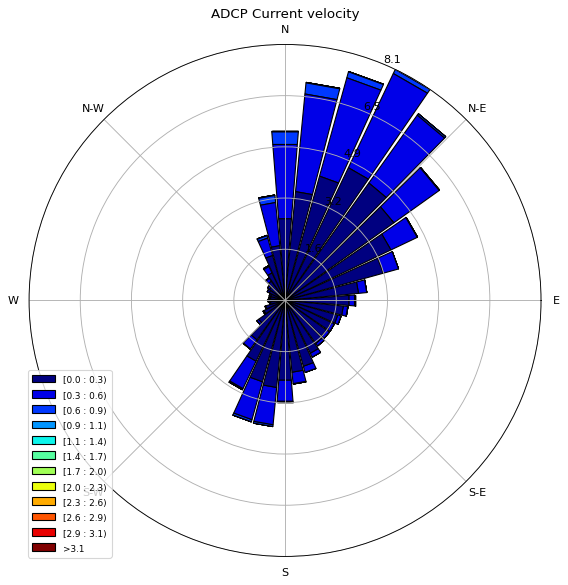

In [4]:
ws = df["ws"]
ws = ws.to_numpy()
wd = df["dp"]
wd = wd.to_numpy()
ax = WindroseAxes.from_ax()
ax.bar(
    wd,
    ws,
    opening=0.9,
    edgecolor="black",
    nsector=36,
    cmap=plt.get_cmap("jet"),
    bins=12,
    normed=True,
)
ax.set_legend()
ax.set_title("ADCP Current velocity")

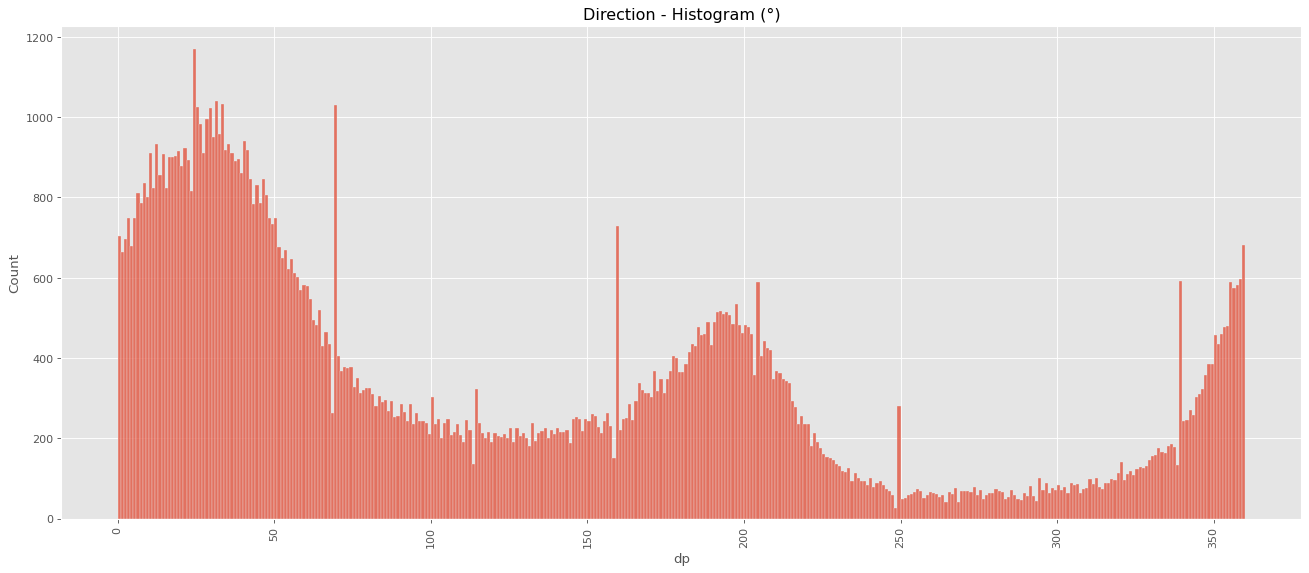

In [6]:
plt.style.use("ggplot")
plt.figure(figsize=(20, 8), dpi=80)
sns.histplot(data=df.to_pandas(), x="dp", bins=360)
plt.xticks(rotation=90)
plt.title("Direction - Histogram (°)")
plt.show()

In [5]:
bins_count, bins_values = np.histogram(df["dp"].drop_nans().to_numpy(), bins=360)
np.argmax(bins_count[:180]) + 1

25

In [3]:
df = pd.read_csv("/content/Currents_praticagem_2015-2023.csv")
df["Datetime"] = pd.to_datetime(df["Datetime"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 886525 entries, 0 to 886524
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype              
---  ------       --------------   -----              
 0   Datetime     886525 non-null  datetime64[ns, UTC]
 1   Velocity_ms  886525 non-null  float64            
 2   Direction    886525 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(2)
memory usage: 20.3 MB


Here the polar histogram shows the main directions of the channel, one around 90° and other around 270°

Text(0.5, 1.0, 'ADCP Current velocity')

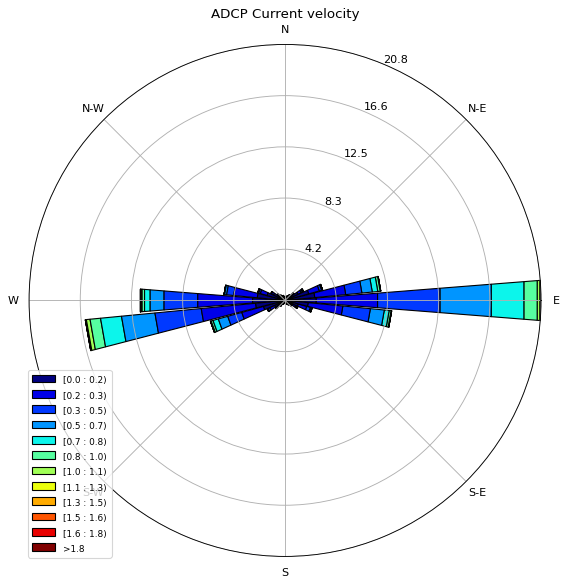

In [4]:
ws = df["Velocity_ms"]
ws = ws.to_numpy()
wd = df["Direction"]
wd = wd.to_numpy()
ax = WindroseAxes.from_ax()
ax.bar(
    wd,
    ws,
    opening=0.9,
    edgecolor="black",
    nsector=36,
    cmap=plt.get_cmap("jet"),
    bins=12,
    normed=True,
)
ax.set_legend()
ax.set_title("ADCP Current velocity")

The same is observed with the traditional histogram

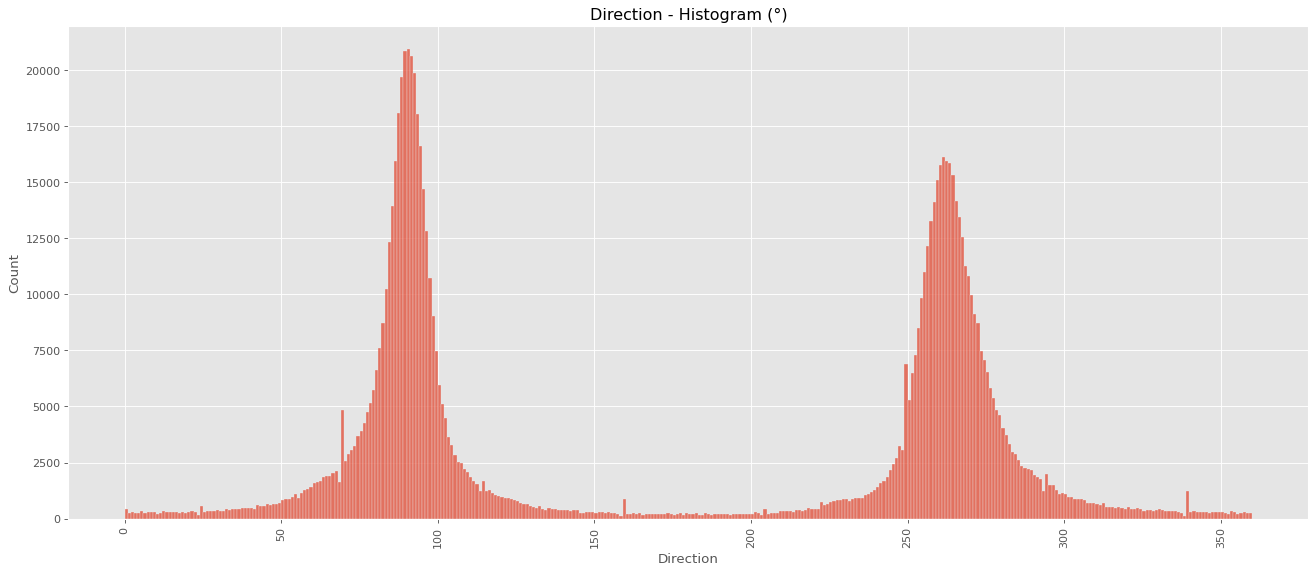

In [5]:
plt.style.use("ggplot")
plt.figure(figsize=(20, 8), dpi=80)
sns.histplot(data=df, x="Direction", bins=360)
plt.xticks(rotation=90)
plt.title("Direction - Histogram (°)")
plt.show()

We will find the two main directions, one smaller and the other larger than 180°, as can b e seen in the histogram above

In [6]:
bins_count, bins_values = np.histogram(df["Direction"].dropna().to_numpy(), bins=360)
np.argmax(bins_count[:180]) + 1

91

In [7]:
np.argmax(bins_count[180:]) + 181

262

We will project the currents in the 91° direction, positive values mean currents entering the channel

In [8]:
df["Projected_current"] = df["Velocity_ms"] * np.cos(np.radians(df["Direction"] - 91))

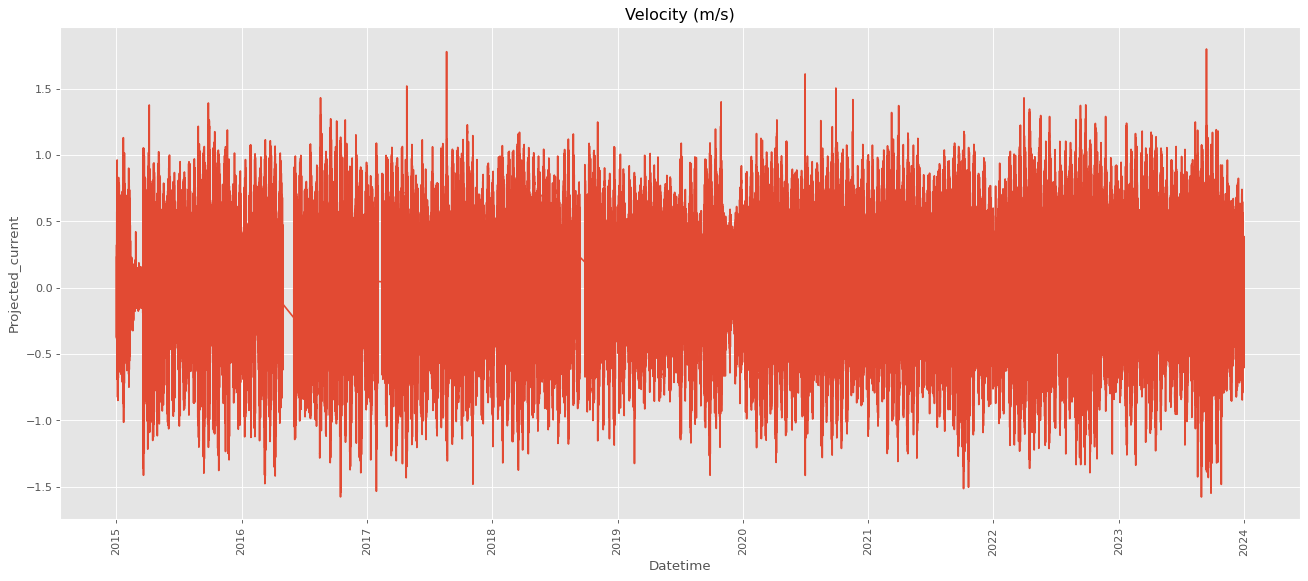

In [9]:
plt.style.use("ggplot")
plt.figure(figsize=(20, 8), dpi=80)
sns.lineplot(data=df, x="Datetime", y="Projected_current")
plt.xticks(rotation=90)
plt.title("Velocity (m/s)")
plt.show()

Save to csv

In [10]:
df.to_csv("Currents_praticagem_projected_2015-2023.csv", index=False)

The same approach is made for the currents from the SOFS model.

In [11]:
df1 = pd.read_csv("/content/current_sofs_praticagem_15min_2019-2023.csv")
df1["Datetime"] = pd.to_datetime(df1["time"])
df1["Velocity_ms"] = df1["vel"]
df1["Direction"] = [
    v if v > 0 else 360 + v for v in df1["dir"]
]  # Values must be positive for the windrose
df1["SSH"] = df1["elev"]
df1.drop(columns=["time", "u", "v", "vel", "dir", "elev"], inplace=True)
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154752 entries, 0 to 154751
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Datetime     154752 non-null  datetime64[ns]
 1   Velocity_ms  154752 non-null  float64       
 2   Direction    154752 non-null  float64       
 3   SSH          154752 non-null  float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 4.7 MB


The two peaks around 70° and 280° can be seen in the two histograms below

Text(0.5, 1.0, 'ADCP Current velocity')

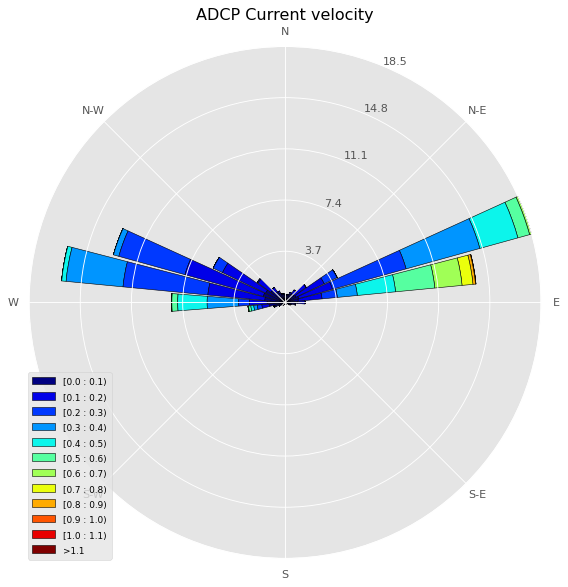

In [12]:
ws = df1["Velocity_ms"]
ws = ws.to_numpy()
wd = df1["Direction"]
wd = wd.to_numpy()
ax = WindroseAxes.from_ax()
ax.bar(
    wd,
    ws,
    opening=0.9,
    edgecolor="black",
    nsector=36,
    cmap=plt.get_cmap("jet"),
    bins=12,
    normed=True,
)
ax.set_legend()
ax.set_title("ADCP Current velocity")

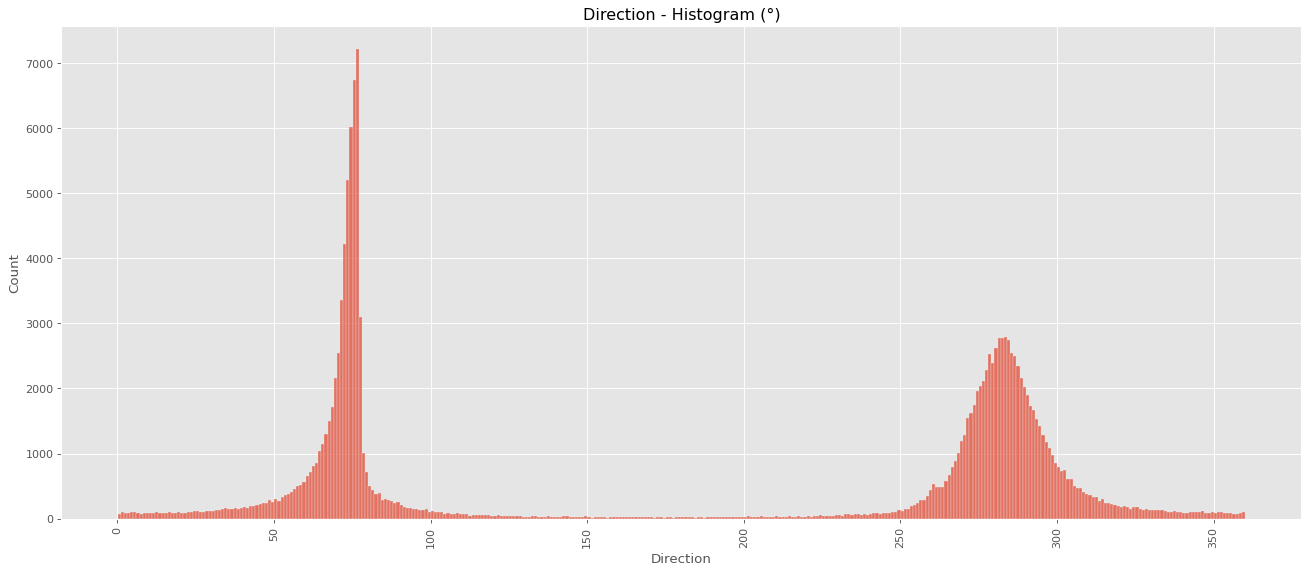

In [13]:
plt.style.use("ggplot")
plt.figure(figsize=(20, 8), dpi=80)
sns.histplot(data=df1, x="Direction", bins=360)
plt.xticks(rotation=90)
plt.title("Direction - Histogram (°)")
plt.show()

Here we find the largest peak below 180° and above 180°

In [14]:
bins_count, bins_values = np.histogram(df1["Direction"].dropna().to_numpy(), bins=360)
np.argmax(bins_count[:180]) + 1

77

In [15]:
np.argmax(bins_count[180:]) + 181

284

We will project the currents in the 77° direction, positive values mean currents entering the channel

In [16]:
df1["Projected_current"] = df1["Velocity_ms"] * np.cos(
    np.radians(df1["Direction"] - 77)
)

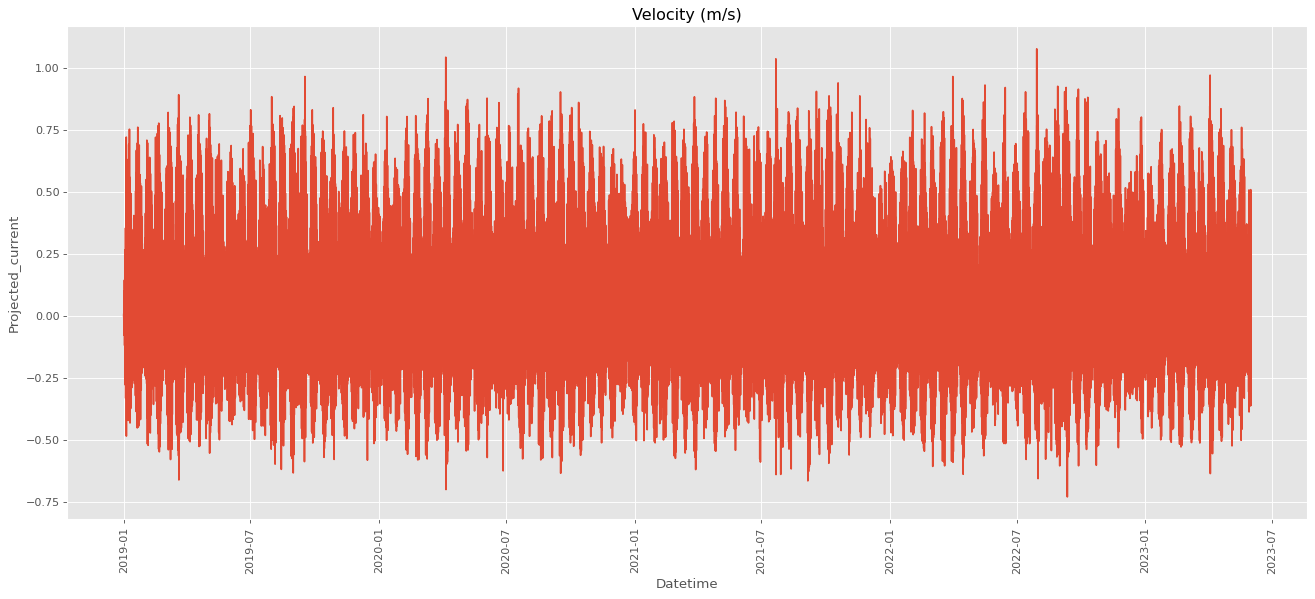

In [17]:
plt.style.use("ggplot")
plt.figure(figsize=(20, 8), dpi=80)
sns.lineplot(data=df1, x="Datetime", y="Projected_current")
plt.xticks(rotation=90)
plt.title("Velocity (m/s)")
plt.show()

Save to CSV

In [18]:
df.to_csv("current_sofs_praticagem_15min_projected_2019-2023.csv", index=False)

Here we do a sanity check where both time series should align since they both are the currents at the same point

In [21]:
import datetime

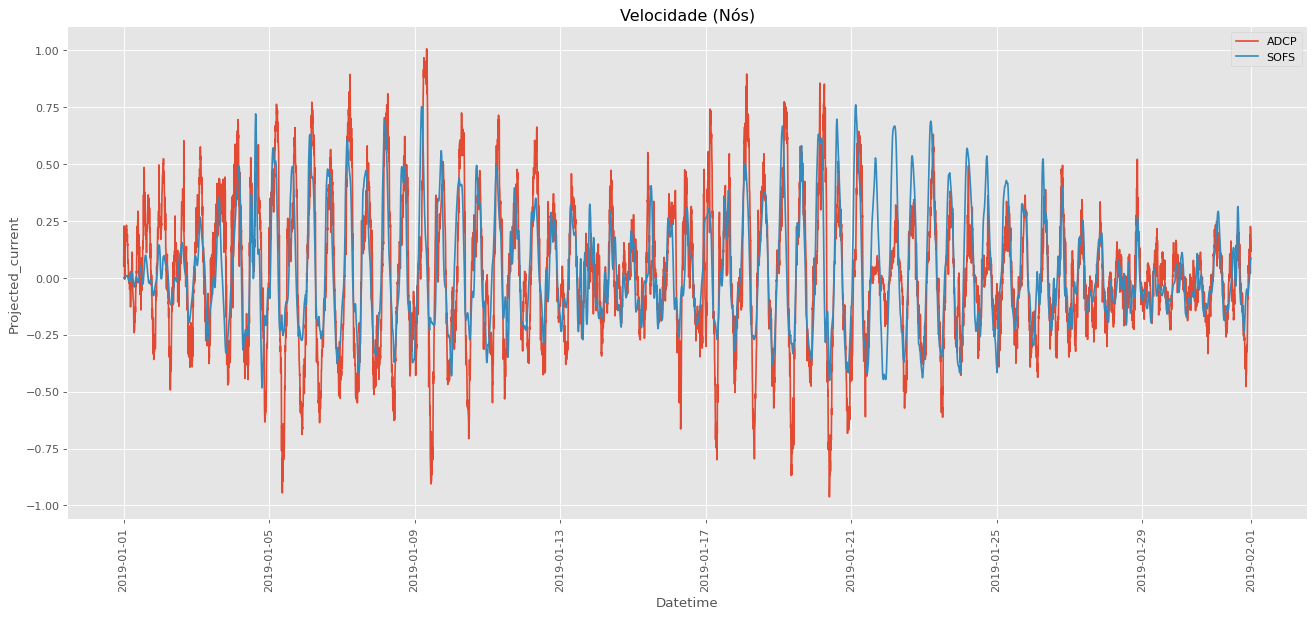

In [36]:
df2 = df.loc[pd.to_datetime(datetime.datetime(2019, 1, 1), utc=True) < df["Datetime"]]
df2 = df2.loc[df2["Datetime"] < pd.to_datetime(datetime.datetime(2019, 2, 1), utc=True)]
df3 = df1.loc[datetime.datetime(2019, 1, 1) < df1["Datetime"]]
df3 = df3.loc[df3["Datetime"] < datetime.datetime(2019, 2, 1)]

plt.style.use("ggplot")
plt.figure(figsize=(20, 8), dpi=80)
sns.lineplot(data=df2, x="Datetime", y="Projected_current", label="ADCP")
sns.lineplot(data=df3, x="Datetime", y="Projected_current", label="SOFS")
plt.legend()
plt.xticks(rotation=90)
plt.title("Velocidade (Nós)")

plt.show()